## Loading data

In [2]:
import pandas as pd

columns_needed = [
    'Severity',
    'Start_Time',
    'Start_Lat',
    'Start_Lng',
    'Street',
    'Visibility(mi)',
    'Weather_Condition',
    'Traffic_Signal'
]

df = pd.read_csv(
    r"C:\Users\User\Desktop\US_Accidents_March23.csv",
    usecols=columns_needed,
    nrows=600000,
    low_memory=True
)

print(df.shape)
print(df.columns)



(600000, 8)
Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Street',
       'Visibility(mi)', 'Weather_Condition', 'Traffic_Signal'],
      dtype='object')


# viewing loaded data

In [3]:
print(df.head())

   Severity           Start_Time  Start_Lat  Start_Lng  \
0         3  2016-02-08 05:46:00  39.865147 -84.058723   
1         2  2016-02-08 06:07:59  39.928059 -82.831184   
2         2  2016-02-08 06:49:27  39.063148 -84.032608   
3         3  2016-02-08 07:23:34  39.747753 -84.205582   
4         2  2016-02-08 07:39:07  39.627781 -84.188354   

                      Street  Visibility(mi) Weather_Condition  Traffic_Signal  
0                     I-70 E            10.0        Light Rain           False  
1                   Brice Rd            10.0        Light Rain           False  
2             State Route 32            10.0          Overcast            True  
3                     I-75 S             9.0     Mostly Cloudy           False  
4  Miamisburg Centerville Rd             6.0     Mostly Cloudy            True  


## Simulating approximate speed limit based on road type

In [5]:
def estimate_speed_limit(street):
    street = str(street)  # convert safely
    
    if 'Hwy' in street or 'Highway' in street:
        return 65
    elif 'Ave' in street:
        return 40
    else:
        return 30

df['Estimated_Speed_Limit'] = df['Street'].apply(estimate_speed_limit)


## Downcast Numeric Types

In [6]:
import numpy as np

# Downcast integers
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='integer')

# Downcast floats
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='float')

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               600000 non-null  int8   
 1   Start_Time             600000 non-null  object 
 2   Start_Lat              600000 non-null  float32
 3   Start_Lng              600000 non-null  float32
 4   Street                 599102 non-null  object 
 5   Visibility(mi)         587535 non-null  float32
 6   Weather_Condition      587996 non-null  object 
 7   Traffic_Signal         600000 non-null  bool   
 8   Estimated_Speed_Limit  600000 non-null  int8   
dtypes: bool(1), float32(3), int8(2), object(3)
memory usage: 22.3+ MB
None


## Feature Engineering

## Convert Time Properly

In [7]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed')

df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
df['Month'] = df['Start_Time'].dt.month

df.drop(columns=['Start_Time'], inplace=True)


## Create Binary Target (Accident Severity)

In [8]:
df['Accident'] = df['Severity'].apply(lambda x: 1 if x >= 3 else 0)

df.drop(columns=['Severity'], inplace=True)


## Encode Road Type From Street

In [9]:
def road_type(street):
    street = str(street)
    if 'Hwy' in street or 'Highway' in street:
        return 3
    elif 'Ave' in street:
        return 2
    elif 'St' in street:
        return 1
    else:
        return 0

df['Road_Type'] = df['Street'].apply(road_type)

df.drop(columns=['Street'], inplace=True)


## Encode Weather Condition

In [10]:
df['Weather_Condition'] = df['Weather_Condition'].astype('category')
df['Weather_Code'] = df['Weather_Condition'].cat.codes

df.drop(columns=['Weather_Condition'], inplace=True)


## Convert Traffic Signal to Integer

In [11]:
df['Traffic_Signal'] = df['Traffic_Signal'].astype(int)


## Handle Missing Visibility

In [13]:
df['Visibility(mi)'] = df['Visibility(mi)'].fillna(
    df['Visibility(mi)'].median()
)


## Check Final Data

In [14]:
print(df.head())
print(df.info())


   Start_Lat  Start_Lng  Visibility(mi)  Traffic_Signal  \
0  39.865147 -84.058723            10.0               0   
1  39.928059 -82.831184            10.0               0   
2  39.063148 -84.032608            10.0               1   
3  39.747753 -84.205582             9.0               0   
4  39.627781 -84.188354             6.0               1   

   Estimated_Speed_Limit  Hour  DayOfWeek  Month  Accident  Road_Type  \
0                     30     5          0      2         1          0   
1                     30     6          0      2         0          0   
2                     30     6          0      2         0          1   
3                     30     7          0      2         1          0   
4                     30     7          0      2         0          0   

   Weather_Code  
0            35  
1            35  
2            49  
3            46  
4            46  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 

## Final Feature / Target Split

In [15]:
X = df.drop('Accident', axis=1)
y = df['Accident']


## Train/Test Split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # IMPORTANT for imbalance
)


## Build Model

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=150,
    max_depth=14,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",150
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",14
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

## Evaluate Model

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


[[54952 20345]
 [ 6157 38546]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.81     75297
           1       0.65      0.86      0.74     44703

    accuracy                           0.78    120000
   macro avg       0.78      0.80      0.77    120000
weighted avg       0.81      0.78      0.78    120000

ROC-AUC: 0.8827673673391697


## Feature Importance

In [24]:
import pandas as pd

importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importance)


Start_Lng                0.278757
Start_Lat                0.261292
Traffic_Signal           0.208752
Road_Type                0.117852
Estimated_Speed_Limit    0.031939
Hour                     0.027412
Weather_Code             0.025409
DayOfWeek                0.023357
Month                    0.015889
Visibility(mi)           0.009340
dtype: float64


## Save Everything Cleanly

In [25]:
import joblib

joblib.dump(model, "traffic_accident_model.pkl")
df.to_csv("processed_accident_data.csv", index=False)


## Plotting ROC-curve

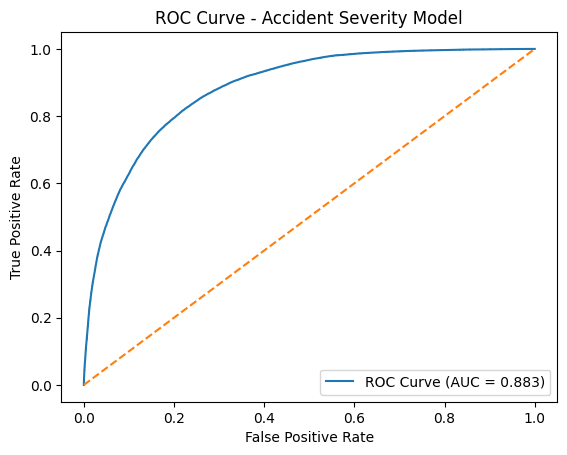

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Accident Severity Model')
plt.legend()
plt.show()


## plot feature importance

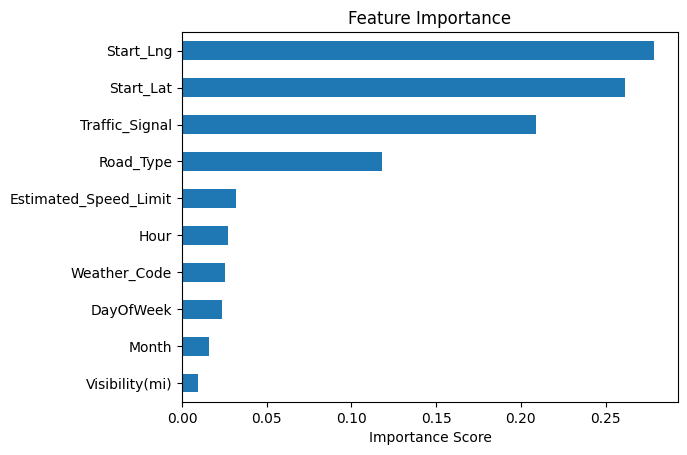

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=True)

plt.figure()
importance.plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()
